Time Series Analysis in Python: An Introduction
https://github.com/Bounteous-Inc/Time-Series-Prediction/blob/master/Time%20Series%20Prediction%20Temp.ipynb

In [1]:
import pandas as pd
import numpy as np
import warnings
import itertools
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller

# Ignore the warning, can comment this 
warnings.filterwarnings("ignore")

# For graphing purpose, can change 
plt.style.use('seaborn-bright')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
import pandas as pd
# Import the data
df_raw = pd.read_csv("./sample_data/transactions-2020-05-11-2021-05-12.csv")
df_raw.head()
df_raw["Date"]+ " " + df_raw["Time"]
df_datetime = pd.to_datetime(df_raw["Date"]+ " " + df_raw["Time"])
df_datetime.head()

df_datetime_sales = pd.concat([df_datetime, df_raw["Gross Sales"].apply(lambda x: float(x[1:]))], axis=1)
df_datetime_sales.columns = ["datetime", "gross_sales"]
df_datetime_sales.head()

,datetime,gross_sales
0,2021-05-11 16:36:42,5.45
1,2021-05-11 16:27:34,5.30
2,2021-05-11 16:26:19,3.80
3,2021-05-11 16:15:10,5.20
4,2021-05-11 16:13:45,17.30


In [3]:
df_raw = pd.read_csv("./sample_data/transactions-2020-05-11-2021-05-12.csv")
df_raw["Orders"] = 1
df = df_raw[["Orders"]]
df['Date'] = pd.to_datetime(df_raw['Date'])
df.head()

# Set the date as index 
df = df.set_index('Date')
# Select the proper time period for weekly aggreagation
df_W = df.resample('W').sum()
df = df.resample('D').sum()
df.head()

,Orders
Date,
2020-05-11,79
2020-05-12,60
2020-05-13,77
2020-05-14,85
2020-05-15,81


Examine and Prepare Your Dataset for Modeling
Check the Data for Common Time Series Patterns

It’s important to check any time series data for patterns that can affect the results, and can inform which forecasting model to use. Some common time series data patterns are:

* Level	The average value in the series
* Trend	Increases, decreases, or stays the same over time
* Seasonal or Periodic	Pattern repeats periodically over time
* Cyclical	Pattern that increases and decreases but usually related to non-seasonal activity, like business cycles
* Random or Irregular Variations	Increases and decreases that don’t have any apparent pattern

side note: cyclic vs. seasonal pattern

Definitions
A seasonal pattern exists when a series is influenced by seasonal factors (e.g., the quarter of the year, the month, or day of the week). Seasonality is always of a fixed and known period. Hence, seasonal time series are sometimes called periodic time series.

A cyclic pattern exists when data exhibit rises and falls that are not of fixed period. The duration of these fluctuations is usually of at least 2 years. Think of business cycles which usually last several years, but where the length of the current cycle is unknown beforehand.

Many people confuse cyclic behaviour with seasonal behaviour, but they are really quite different. If the fluctuations are not of fixed period then they are cyclic; if the period is unchanging and associated with some aspect of the calendar, then the pattern is seasonal. In general, the average length of cycles is longer than the length of a seasonal pattern, and the magnitude of cycles tends to be more variable than the magnitude of seasonal patterns.

Most time-series data will contain one or more, but probably not all of these patterns. It’s still a good idea to check for them since they can affect the performance of the model and may even require different modeling approaches.

Two great methods for finding these data patterns are visualization and decomposition.

# Visualize the Data
The first step is simply to plot the dataset. In the example, I use the matplotlib package. Since it’s easier to see a general trend using the mean, I use both the original data (blue line) as well as the monthly average resample data (orange line).

By changing the 'M’ (or ‘Month’) within y.resample('M'), you can plot the mean for different aggregate dates. For example, if you have a very long history of data, you might plot the yearly average by changing ‘M’ to ‘Y’. 

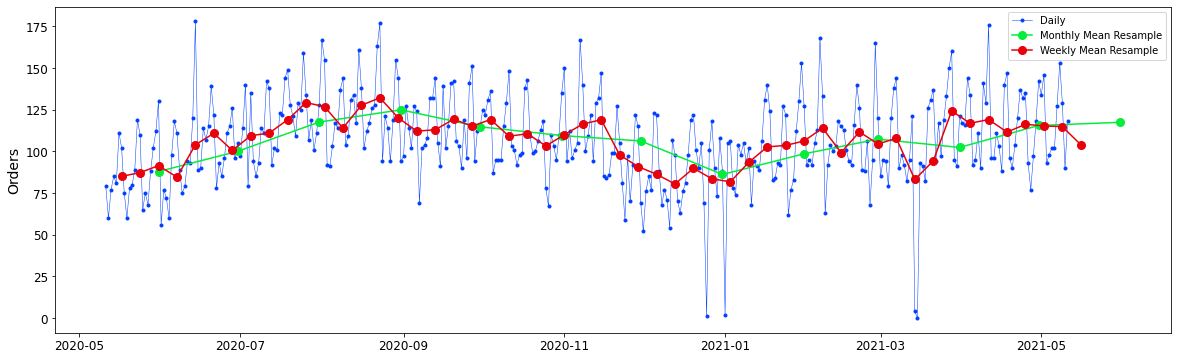

In [4]:
import warnings
import matplotlib.pyplot as plt
y = df['Orders']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.plot(y.resample('W').mean(),marker='o', markersize=8, linestyle='-', label='Weekly Mean Resample')
ax.set_ylabel('Orders')
ax.legend();

Then we can look at the basic up/down patterns, overall trend, anomalies, and generally get a sense of what kind of data we’re dealing with. This is just a gut check of the data without going too deep. If there are any very strange anomalies, we might reach out to a subject matter expert to understand possible causes. We are also looking here for any red flags like missing data or other obvious quality issues.

# Decompose the Data
By looking at the graph of sales data above, we can see a general increasing trend with no clear pattern of seasonal or cyclical changes. The next step is to decompose the data to view more of the complexity behind the linear visualization. A useful Python function called seasonal_decompose within the 'statsmodels' package can help us to decompose the data into four different components:

* Observed
* Trended
* Seasonal
* Residual

Side note: tsa in statsmodels.api.tsa stands for time series analysis

In [5]:
import statsmodels.api as sm

# graphs to show seasonal_decompose
def seasonal_decompose (y, model='additive'):
    decomposition = sm.tsa.seasonal_decompose(y, model=model,extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

In [6]:
decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
df_decompose = pd.concat([decomposition.observed,
                          decomposition.trend,
                          decomposition.seasonal,                        
                          decomposition.resid], axis=1)
df_decompose.head()

,Orders,trend,seasonal,resid
Date,,,,
2020-05-11,79.0,83.918367,-18.567506,13.649138
2020-05-12,60.0,84.061224,-14.492515,-9.568709
2020-05-13,77.0,84.204082,-8.183424,0.979342
2020-05-14,85.0,85.000000,-7.561367,7.561367
2020-05-15,81.0,84.428571,-0.322356,-3.106215


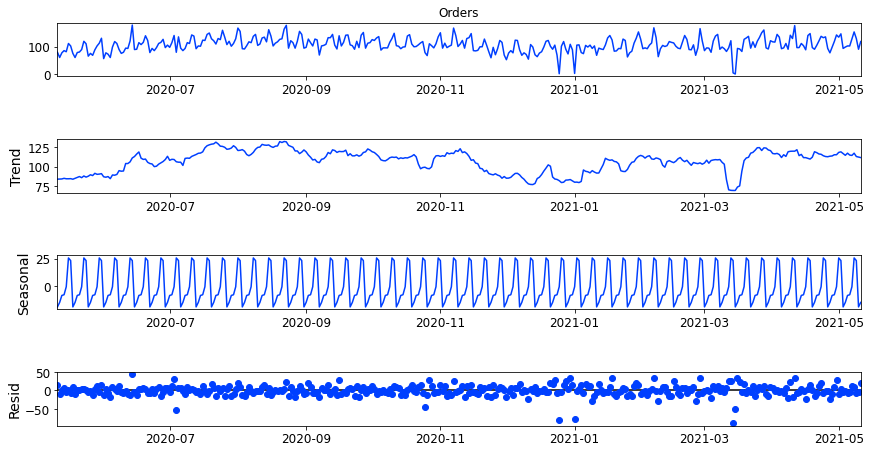

In [7]:
seasonal_decompose(y)

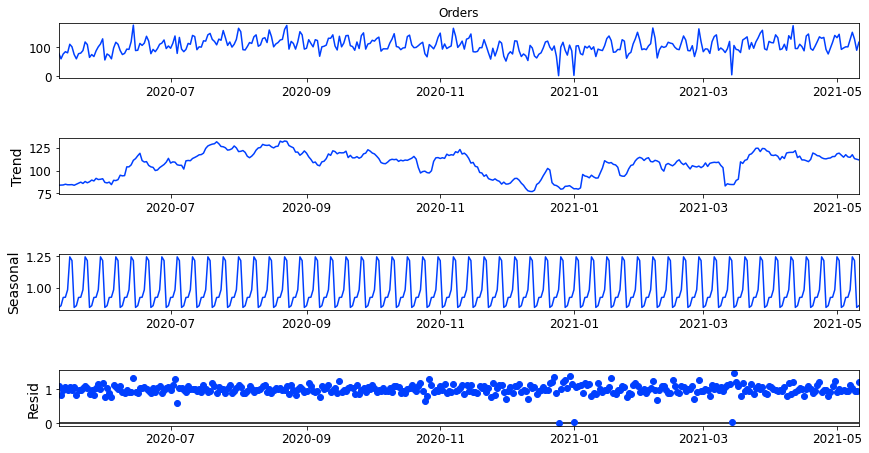

In [8]:
# graphs to show seasonal_decompose (use multiplicative model, need to make sure value > 0)

y_nonzero = df['Orders']
y_nonzero[y_nonzero==0]=y_nonzero.mean()
seasonal_decompose(y_nonzero, model='multiplicative')

(This is just a template to analyse the data)

After looking at the four pieces of decomposed graphs, we can tell that our sales dataset has an overall increasing trend as well as a ~~yearly~~ weekly seasonality. Depending on the components of your dataset like trend, seasonality, or cycles, your choice of model will be different. We discuss evaluating and choosing models in Part Two.

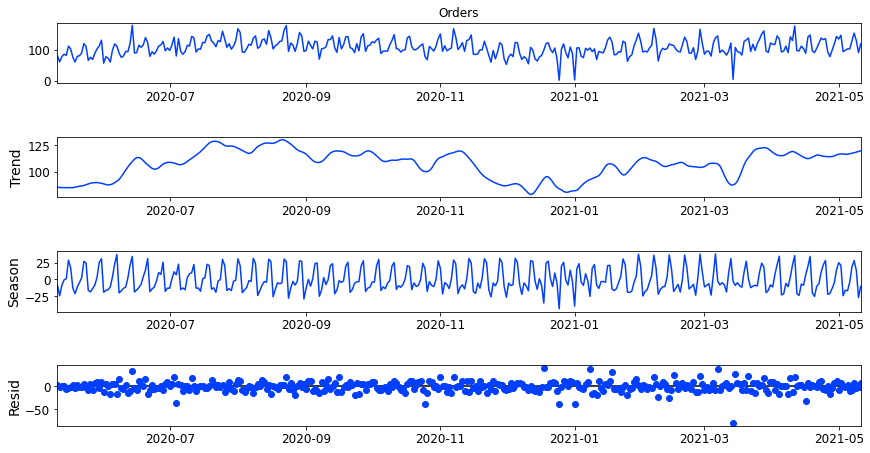

In [9]:
# using STL 
# ref: https://www.statsmodels.org/devel/generated/statsmodels.tsa.seasonal.STL.html
# ref: https://medium.com/quantjam/introduction-to-time-series-trend-decomposition-with-python-b54a29f8e038
from statsmodels.tsa.seasonal import STL
decompose_stl = STL(y).fit()
decompose_stl
fig = decompose_stl.plot()
fig.set_size_inches(14,7)
plt.show()

# Check for Stationarity
Next, we need to check whether the dataset is stationary or not. A dataset is stationary if its statistical properties like mean, variance, and autocorrelation do not change over time.

Most time series datasets related to business activity are not stationary since there are usually all sorts of non-stationary elements like trends and economic cycles. But, since most time series forecasting models use stationarity—and mathematical transformations related to it—to make predictions, we need to ‘stationarize’ the time series as part of the process of fitting a model.

Two common methods to check for stationarity are Visualization and the Augmented Dickey-Fuller (ADF) Test. Python makes both approaches easy:



# Visualization 
This method graphs the rolling statistics (mean and variance) to show at a glance whether the standard deviation changes substantially over time:

Side note: rooling window

The size of the rolling window is related to the timescales of the system (response times). For systems with fast timescales short windows can be appropriate, whereas systems with slow timescales require longer rolling windows for the metrics to be able to capture changes in the signature of the time series. Typically, we use rolling windows equal to half the length of the timeseries. Short rolling windows lead to irregular trends in the estimates of the metrics. Long rolling windows smooth out the trends. Also, the shorter the rolling window is, the less accurate the estimate of the metric becomes. Again, just like with filtering, there is no golden rule for the right size of the rolling window. There is a trade-off between having a long enough window to estimate the metrics and short enough to have a sufficient number of windows in order to be able to derive a trend.


In [10]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title, window_size=7):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=window_size).mean() 
    rolstd = pd.Series(timeseries).rolling(window=window_size).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

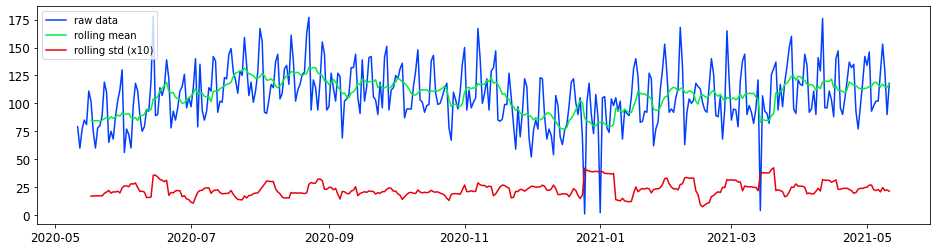

In [11]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')

(this is just a template)
Both the mean and standard deviation for stationary data does not change much over time. But in this case, since the y-axis has such a large scale, we can not confidently conclude that our data is stationary by simply viewing the above graph. Therefore, we should do another test of stationarity.

Augmented Dickey-Fuller Test
The ADF approach is essentially a statistical significance test that compares the p-value with the critical values and does hypothesis testing. Using this test, we can determine whether the processed data is stationary or not with different levels of confidence.

In [12]:
dftest = adfuller(y.dropna(), autolag='AIC')
dftest

(-2.4887133862430333,
 0.11824468694371859,
 14,
 351,
 {'1%': -3.44911857009962,
  '5%': -2.8698097654570507,
  '10%': -2.5711757061225153},
 3062.596205792246)

In [13]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'
              .format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [14]:
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = -2.489
P-value = 0.118
Critical values :
	1%: -3.44911857009962 - The data is not stationary with 99% confidence
	5%: -2.8698097654570507 - The data is not stationary with 95% confidence
	10%: -2.5711757061225153 - The data is not stationary with 90% confidence


Looking at both the visualization and ADF test, we can tell that our sample sales data is non-stationary. 

# Make the Data Stationary
To proceed with our time series analysis, we need to stationarize the dataset. There are many approaches to stationarize data, but we’ll use de-trending, differencing, and then a combination of the two.

# Detrending
This method removes the underlying trend in the time series:

 > Is the de-trended data stationary ?
Test statistic = -6.483
P-value = 0.000
Critical values :
	1%: -3.449559661646851 - The data is  stationary with 99% confidence
	5%: -2.8700035112469626 - The data is  stationary with 95% confidence
	10%: -2.5712790073013796 - The data is  stationary with 90% confidence


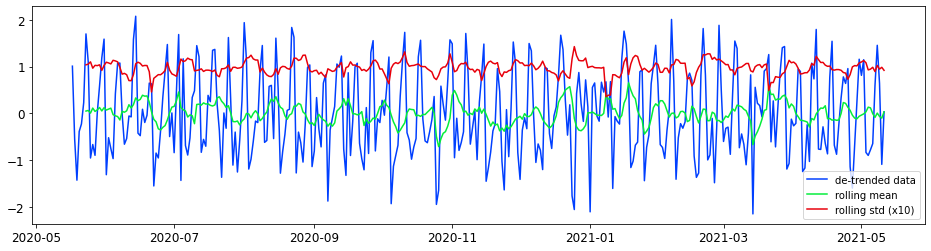

In [15]:
# Detrending
y_detrend =  (y - y.rolling(window=7).mean())/y.rolling(window=7).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

The results show that the data is now stationary, indicated by the relative smoothness of the rolling mean and rolling standard deviation after running the ADF test again.



# Differencing
This method removes the underlying seasonal or cyclical patterns in the time series. Since the sample dataset has a ~~12-month seasonality, I used a 12-lag difference:~~
7-day seasonality, I used a 7-lag difference:

 > Is the 12 lag differenced data stationary ?
Test statistic = -4.910
P-value = 0.000
Critical values :
	1%: -3.4496162602188187 - The data is  stationary with 99% confidence
	5%: -2.870028369720798 - The data is  stationary with 95% confidence
	10%: -2.5712922615505627 - The data is  stationary with 90% confidence


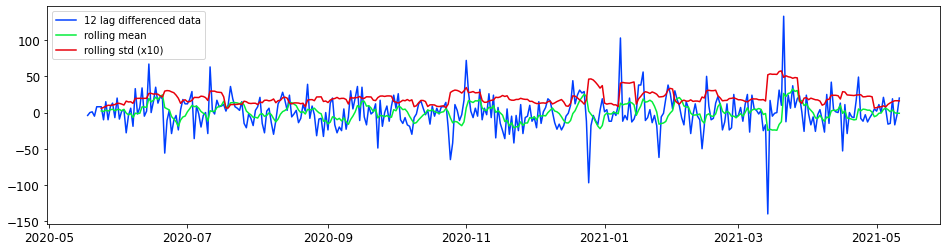

In [16]:
# Differencing
# y_12lag =  y - y.shift(12)
y_12lag =  y - y.shift(7)

test_stationarity(y_12lag,'12 lag differenced data')
ADF_test(y_12lag,'12 lag differenced data')

This method did not perform as well as the de-trending did, as indicated by the ADF test which is not stationary within 99 percent of the confidence interval.

# Combining Detrending and Differencing
This approach uses both methods to stationarize the data.

 > Is the 12 lag differenced de-trended data stationary ?
Test statistic = -10.392
P-value = 0.000
Critical values :
	1%: -3.4497880749874628 - The data is  stationary with 99% confidence
	5%: -2.870103829170425 - The data is  stationary with 95% confidence
	10%: -2.571332495975496 - The data is  stationary with 90% confidence


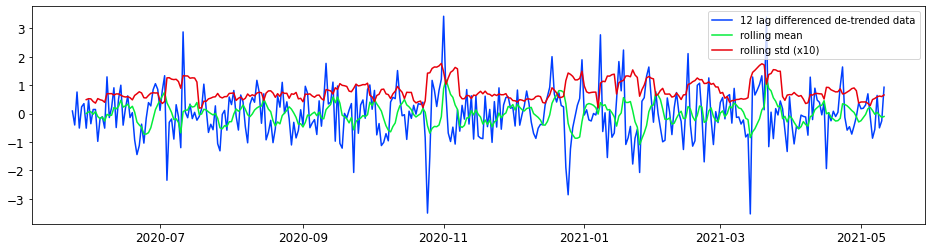

In [17]:
# Detrending + Differencing

y_12lag_detrend =  y_detrend - y_detrend.shift(7)

test_stationarity(y_12lag_detrend,'12 lag differenced de-trended data')
ADF_test(y_12lag_detrend,'12 lag differenced de-trended data')

Using the combination of the two methods, we see from both the visualization and the ADF test that the data is now stationary. This is the transformation we will use moving forward with our analysis.

# Create Training & Testing Datasets
To get ready to evaluate the performance of the models you’re considering for your time series analysis, it’s important to split the dataset into at least two parts.

One part will be the ‘Training’ dataset, and the other part will be the ‘Testing’ dataset. Sometimes you will create a third dataset or a ‘Validation’ dataset which reserves some data for additional testing.

For the purposes of this sample time series analysis, I created just a Training dataset and a Testing dataset.

Set the y_to_train, y_to_test, and the length of predict units

In [18]:
split_boundry = round(len(y)*4/5)
y_to_train = y[:split_boundry] # dataset to train
y_to_val = y[split_boundry:] # last X months for test  
predict_date = len(y) - len(y[:split_boundry]) # the number of data points for the test set

# Conclusion
By now you may be getting impatient for the actual model building. This is normal since most people find the model building and evaluation more interesting.

Though it may seem like a lot of prep work, it’s absolutely necessary. Like a good house painter, it saves time, trouble, and mistakes if you take the time to make sure you understand and prepare your data well before proceeding. Good data preparation also makes it easier to make adjustments and find ways to improve your model’s fit, as well as research potential questions about the results.

I hope this post has provided a good overview of some of the important data preparation steps in building a time series model. In Part Two, we’ll jump right into the exciting part: Modeling!

Remember that all the code referenced in this post 

# Part II

# Choosing a Time Series Prediction Model

Before we walk through the various models, I want to make an important point: Not all of these models are suitable for the sample dataset we’re using in this blog post. But, I am walking through them anyway to describe some of the options, and to show how and why not all models are appropriate for all datasets.

The appropriate model for your time-series data will depend on the data’s particular characteristics, for example, if the dataset has an overall trend or seasonality. Please be sure to choose the model that best suits your data.

To help us evaluate the performance of each forecasting model, we need to measure the differences between predicted values and the actual or observed values. For the models I present below, I used the commonly-used measurement metric root-mean-square error (RMSE) also referred to as root-mean-square deviation (RMSD).

Other measures commonly used are forecast error, mean absolute error (MAE), and mean absolute percentage error (MAPE). When testing more than one model, be sure to use the same performance metric consistently across all of them. 

Now let’s consider four forecasting models:

* Simple Exponential Smoothing (SES) for data without trend or seasonality
* Holt’s Linear Trend Method for data with a trend but no seasonality
* Holt-Winters’ Seasonal Method for data with trend and/or seasonality
* SARIMA for data with trend and/or seasonality

# Simple Exponential Smoothing (SES)

Suitable for time series data without trend or seasonal components

This model calculates the forecasting data using weighted averages. One important parameter this model uses is the smoothing parameter: α, and you can pick a value between 0 and 1 to determine the smoothing level. When α = 0, the forecasts are equal to the average of the historical data. When α = 1, the forecasts will be equal to the value of the last observation.

You can either choose a specific α (e.g., in the sample code, I used 0.8) or use the Python ‘statsmodels’ module to automatically find an optimized value for the dataset. I usually use the auto-optimization approach which gives us the lowest error, but if you want to be more conservative or aggressive, you can specify α.

In [19]:
import numpy as np
from statsmodels.tsa.api import SimpleExpSmoothing 

def ses(y, y_to_train,y_to_test,smoothing_level,predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = SimpleExpSmoothing(y_to_train).fit(smoothing_level=smoothing_level,optimized=False)
    fcast1 = fit1.forecast(predict_date).rename(r'$\alpha={}$'.format(smoothing_level))
    # specific smoothing level
    fcast1.plot(marker='o', color='blue', legend=True)
    fit1.fittedvalues.plot(marker='o',  color='blue')
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with smoothing level of {} is {}'.format(smoothing_level,round(np.sqrt(mse1), 2)))
    
    ## auto optimization
    fit2 = SimpleExpSmoothing(y_to_train).fit()
    fcast2 = fit2.forecast(predict_date).rename(r'$\alpha=%s$'%fit2.model.params['smoothing_level'])
    # plot
    fcast2.plot(marker='o', color='green', legend=True)
    fit2.fittedvalues.plot(marker='o', color='green')
    
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with auto optimization is {}'.format(round(np.sqrt(mse2), 2)))
    
    plt.show()

The Root Mean Squared Error of our forecasts with smoothing level of 0.8 is 46.22
The Root Mean Squared Error of our forecasts with auto optimization is 25.97


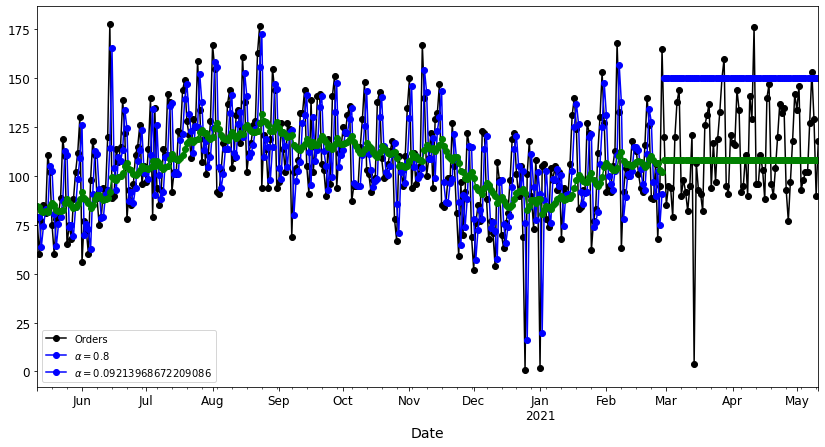

In [20]:
ses(y, y_to_train,y_to_val,0.8,predict_date)

# Holt’s Linear Trend Method

Suitable for time series data with a trend component but without a seasonal component 

Expanding the SES method, the Holt method helps you forecast time series data that has a trend. In addition to the level smoothing parameter α introduced with the SES method, the Holt method adds the trend smoothing parameter β*. Like with parameter α, the range of β* is also between 0 and 1.

The sample code below contains two different variants within the Holt method. Both fits have the α = 0.6, β* = 0.2 as parameter values. The fit1 is the default Holt’s additive model, and the fit2 is an exponential model. An exponential model would be appropriate for situations where the increase or decrease starts slowly but then accelerates rapidly.

In [21]:
from statsmodels.tsa.api import Holt

def holt(y,y_to_train,y_to_test,smoothing_level,smoothing_slope, predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = Holt(y_to_train).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast1 = fit1.forecast(predict_date).rename("Holt's linear trend")
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Linear trend {}'.format(round(np.sqrt(mse1), 2)))

    fit2 = Holt(y_to_train, exponential=True).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast2 = fit2.forecast(predict_date).rename("Exponential trend")
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Exponential trend {}'.format(round(np.sqrt(mse2), 2)))
    
    fit1.fittedvalues.plot(marker="o", color='blue')
    fcast1.plot(color='blue', marker="o", legend=True)
    fit2.fittedvalues.plot(marker="o", color='red', legend=True)
    fcast2.plot(color='red', marker="o", legend=True)
    
    axes = plt.gca()
    axes.set_ylim([-10,600])
    plt.show()
    
# holt(y, y_to_train,y_to_val,0.6,0.2,predict_date)

The Root Mean Squared Error of Holts Linear trend 308.83
The Root Mean Squared Error of Holts Exponential trend 19220.63


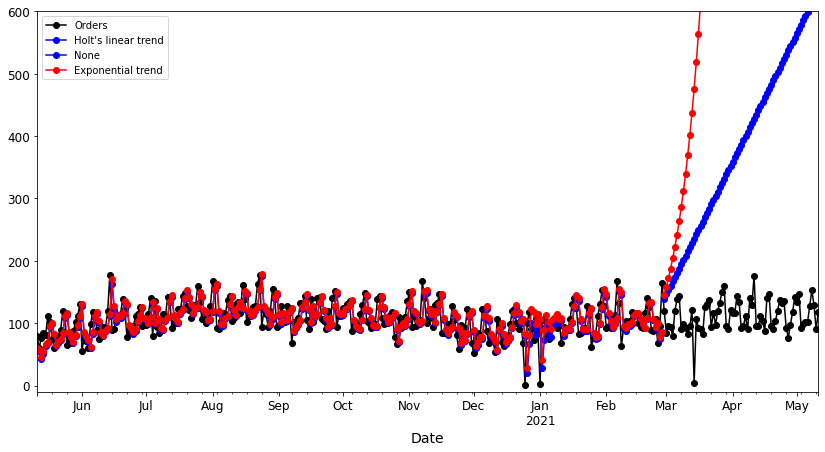

In [22]:
holt(y, y_to_train,y_to_val,0.6,0.2,predict_date)

Looking at the visualization for the Holt method, we see how the linear trend (blue line) and exponential trend (red line) compare to each other and to the order volumes. Compared with SES, Holt captures more of the trend of the data. However, as you can see from the visual, the trend it discovered is too dramatic and would be very unlikely to take place in real life.

# Holt-Winters’ Seasonal Method
Suitable for time series data with trend and/or seasonal components

The Holt-Winters model extends Holt to allow the forecasting of time series data that has both trend and seasonality, and this method includes this seasonality smoothing parameter: γ.

There are two general types of seasonality: Additive and Multiplicative. 

* Additive: xt = Trend + Seasonal + Random

Seasonal changes in the data stay roughly the same over time and don’t fluctuate in relation to the overall data.

* Multiplicative: xt = Trend * Seasonal * Random

The seasonal variation changes in relation to the overall changes in the data. So, if the data is trending upward, the seasonal differences grow proportionally as well.
Here’s a helpful visual:

Once you figure out which type of seasonality you’re dealing with in your data, you can identify the frequency of seasonality or m. For data with a quarterly seasonal pattern, m = 4, while for a monthly seasonal data pattern, m = 12. Our sample data has a yearly seasonal pattern with 2 years of data, and we aggregated it by week, so each data point is one week, so m = 52.

The Python statsmodels module provides users with a range of parameter combinations based on the trend types, seasonality types, and other options for doing Box-Cox transformations. This package is kind of like the time series version of grid search for hyperparameter tuning. To find out more, see this documentation and this detailed explanation to help you choose the one that suits your data best.

In [23]:
from statsmodels.tsa.api import ExponentialSmoothing

def holt_win_sea(y,y_to_train,y_to_test,seasonal_type,seasonal_period,predict_date):
    
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    if seasonal_type == 'additive':
        fit1 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add').fit(use_boxcox=True)
        fcast1 = fit1.forecast(predict_date).rename('Additive')
        mse1 = ((fcast1 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'
              .format(seasonal_period,round(np.sqrt(mse1), 2)))
        
        fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
        fcast2 = fit2.forecast(predict_date).rename('Additive+damped')
        mse2 = ((fcast2 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'
              .format(seasonal_period,round(np.sqrt(mse2), 2)))
        
        fit1.fittedvalues.plot(style='--', color='red')
        fcast1.plot(style='--', marker='o', color='red', legend=True)
        fit2.fittedvalues.plot(style='--', color='green')
        fcast2.plot(style='--', marker='o', color='green', legend=True)
    
    elif seasonal_type == 'multiplicative':  
        fit3 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul').fit(use_boxcox=True)
        fcast3 = fit3.forecast(predict_date).rename('Multiplicative')
        mse3 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse3), 2)))
        
        fit4 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
        fcast4 = fit4.forecast(predict_date).rename('Multiplicative+damped')
        mse4 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'
              .format(seasonal_period,round(np.sqrt(mse4), 2)))
        
        fit3.fittedvalues.plot(style='--', color='red')
        fcast3.plot(style='--', marker='o', color='red', legend=True)
        fit4.fittedvalues.plot(style='--', color='green')
        fcast4.plot(style='--', marker='o', color='green', legend=True)
        
    else:
        print('Wrong Seasonal Type. Please choose between additive and multiplicative')

    plt.show()

The Root Mean Squared Error of additive trend, additive seasonal of period season_length=7 and a Box-Cox transformation 20.54
The Root Mean Squared Error of additive damped trend, additive seasonal of period season_length=7 and a Box-Cox transformation 21.03


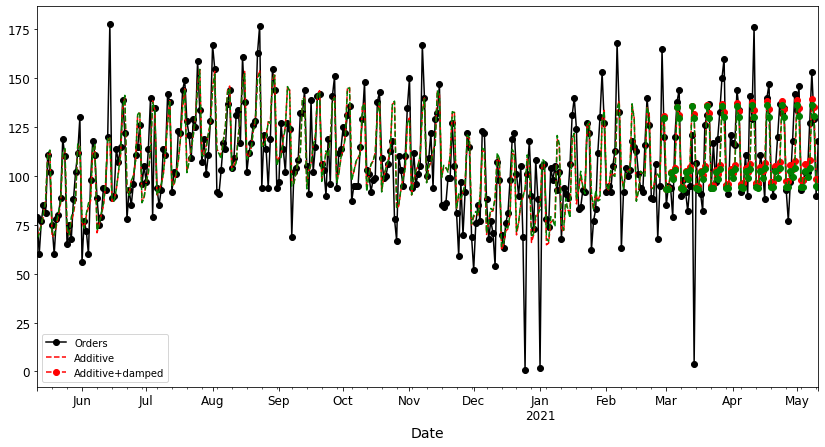

In [24]:
holt_win_sea(y, y_to_train,y_to_val,'additive',7, predict_date)

In [25]:
# experiment: use holtwinters for decomposition (note: trend is very small)
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# y,y_to_train,y_to_test, y_to_value
model_hwes = ExponentialSmoothing(y_to_train,
                               seasonal_periods=7, trend='add', seasonal='mul').fit()
# model_ht.predict(0,100)
df_hwes = pd.concat([y_to_train,
                     model_hwes.trend,
                     model_hwes.season,
                     model_hwes.resid], axis=1)
df_hwes.columns = ["data", "trend", "season", "resid"]
df_hwes.head()

,data,trend,season,resid
Date,,,,
2020-05-11,79.00000000,0.05956862,1.20103580,6.38517936
2020-05-12,60.00000000,0.05952484,1.23413116,-15.62689932
2020-05-13,77.00000000,0.05952071,1.31994770,-1.57728130
2020-05-14,85.00000000,0.05953581,1.33254733,5.82096231
2020-05-15,81.00000000,0.05952902,1.39321775,-2.73628499


In [26]:
model_hwes.summary()

Dep. Variable:,Orders,No. Observations:,293
Model:,ExponentialSmoothing,SSE,78226.917
Optimized:,True,AIC,1659.049
Trend:,Additive,BIC,1699.530
Seasonal:,Multiplicative,AICC,1660.353
Seasonal Periods:,7,Date:,"Wed, 23 Jun 2021"
Box-Cox:,False,Time:,20:46:27
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1427869,alpha,True
smoothing_trend,2.4217e-05,beta,True


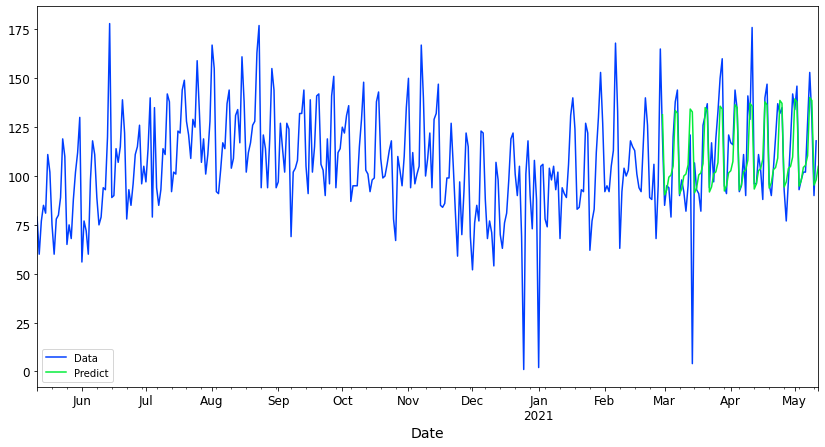

In [27]:
model_hwes.predict(0, len(y))
# model_hwes.forecast(len(y)-len(y_to_train))
fig, ax = plt.subplots(1,1, figsize=(14, 7))

ax = y.plot()
ax = model_hwes.predict(len(y_to_train), len(y)).plot()
# ax = model_hwes.predict(0, len(y)).plot()
ax.legend(["Data", "Predict"])
plt.show()

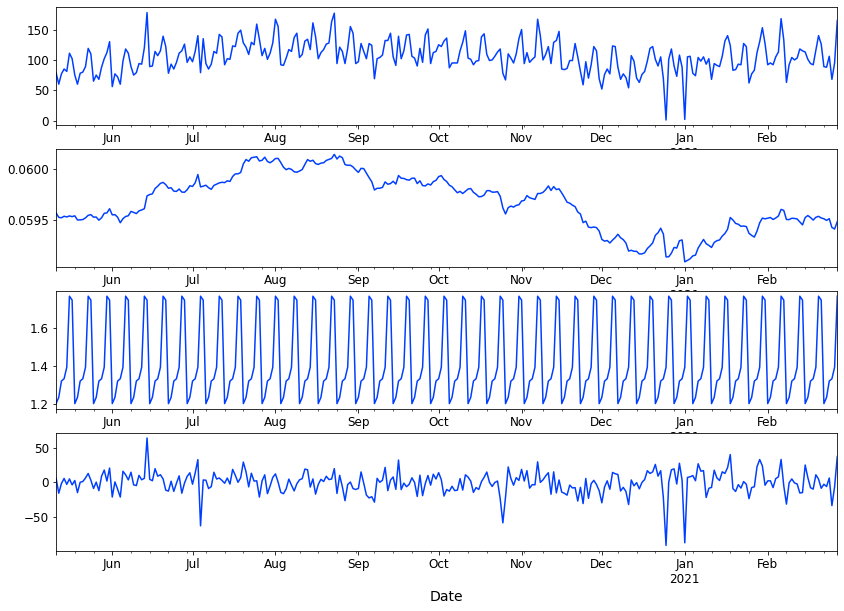

In [28]:
fig, ax = plt.subplots(4,1, figsize=(14,10))
df_hwes.data.plot(ax=ax[0])
df_hwes.trend.plot(ax=ax[1])
df_hwes.season.plot(ax=ax[2])
df_hwes.resid.plot(ax=ax[3])
plt.show()

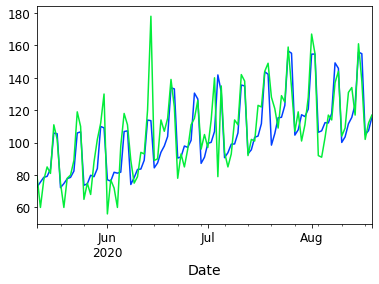

In [30]:
fig = model_hwes.predict(0,100).plot()
fig = y[:101].plot()
plt.show()

The Root Mean Squared Error of additive trend, multiplicative seasonal of period season_length=7 and a Box-Cox transformation 20.96
The Root Mean Squared Error of additive damped trend, multiplicative seasonal of period season_length=7 and a Box-Cox transformation 20.96


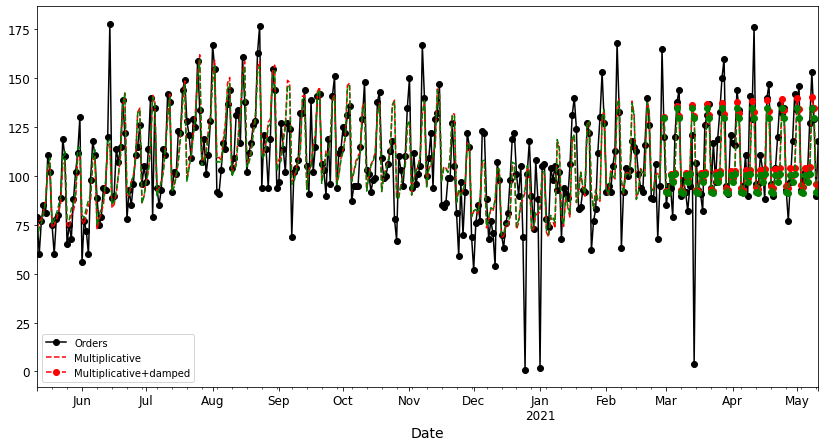

In [31]:
holt_win_sea(y, y_to_train,y_to_val,'multiplicative',7, predict_date)

# SARIMA
Suitable for time series data with trend and/or seasonal components

While exponential smoothing models use weighted averages of past observations to forecast new values, Auto-Regressive Integrated Moving Average or ARIMA models look at autocorrelations or serial correlations in the data. In other words, ARIMA models look at differences between values in the time series. You can learn more about ARIMA models here. SARIMA builds upon the concept of ARIMA but extends it to model the seasonal elements in your data. 
 
You’ll notice that SARIMA includes several parameters that can be tuned to achieve optimal performance. You can learn more about these parameters here. They are:
 
Trend Elements:

p: Trend autoregression order.
d: Trend difference order.
q: Trend moving average order.
Seasonal Elements:

P: Seasonal autoregressive order.
D: Seasonal difference order.
Q: Seasonal moving average order.
m: The number of time steps for a single seasonal period.
In order to get the best prediction, it’s important to find the values of SARIMA(p,d,q)(P,D,Q)m that optimize a metric of interest. For the purposes of this brief blog post, we will just use a "grid search" to iteratively explore different combinations of parameters. Learn more about grid search.

The evaluation metric we’ll use for the grid search is the AIC (Akaike Information Criterion) value. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. In general, we want to pick the combination with the lowest AIC value.

In [32]:
import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'
          .format(param_mini, param_seasonal_mini, mini))

In [33]:
sarima_grid_search(y,7)

The set of parameters with the minimum AIC is: SARIMA(1, 1, 1)x(0, 1, 1, 7) - AIC:3019.8039617364116


The grid search tested all possible combinations of variables, and printed out the set that resulted in the lowest AIC, and we can see that SARIMA(1, 1, 1)x(1, 1, 0, 52) has the lowest AIC value. Since this method chose the best parameters, we will use this method to fit our model and compare the results with all the previous models discussed above.

In [34]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'
          .format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'
          .format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

Here are the visualizations for the SARIMA method. Compared with the results of all the previous models, we can be confident saying the SARIMA model best captures both the seasonality and trend of our dataset. Its forecasted results are closest to the actual sales.

In addition to using the Root Mean Squared Error (RMSE) metric, I also ran plot_diagnostics( ), which is a really valuable function to ensure that none of the assumptions made by the model have been violated, and that there is no unusual behavior. The dynamic=False argument ensures that we produce one-step-ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point. Unfortunately, this is a function that can only be built inside the SARIMA and ARIMA packages, so we cannot print out the same results for the other models we have considered.

In [35]:
y.iloc[[split_boundry]].index.values[0]

numpy.datetime64('2021-02-28T00:00:00.000000000')

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0950      0.058      1.626      0.104      -0.020       0.210
ma.L1         -0.8795      0.034    -25.880      0.000      -0.946      -0.813
ar.S.L7        0.0013      0.037      0.035      0.972      -0.070       0.073
ma.S.L7       -1.0204      0.046    -22.186      0.000      -1.111      -0.930
sigma2       299.1232     27.576     10.847      0.000     245.075     353.171


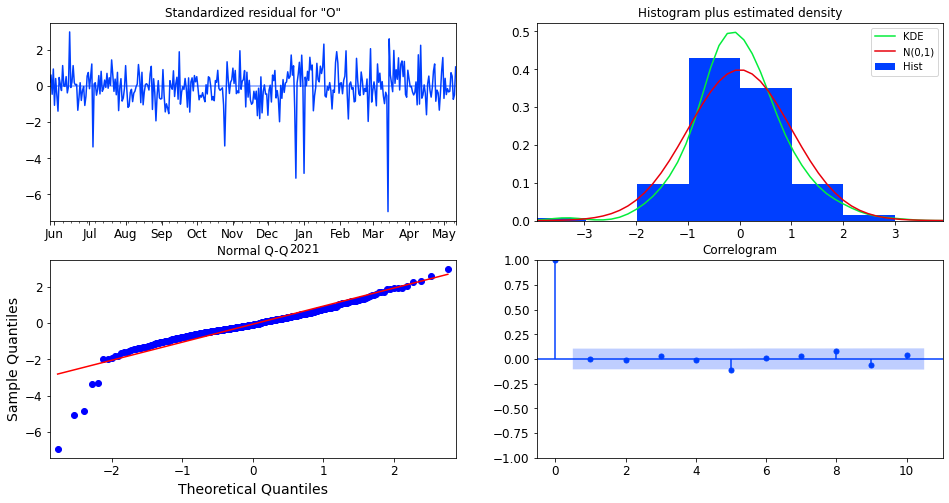

The Root Mean Squared Error of SARIMA with season_length=7 and dynamic = False 21.02


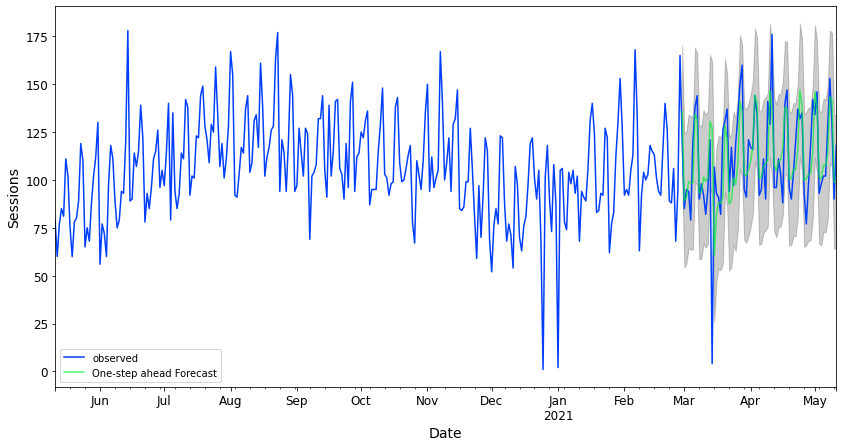

The Root Mean Squared Error of SARIMA with season_length=7 and dynamic = True 20.43


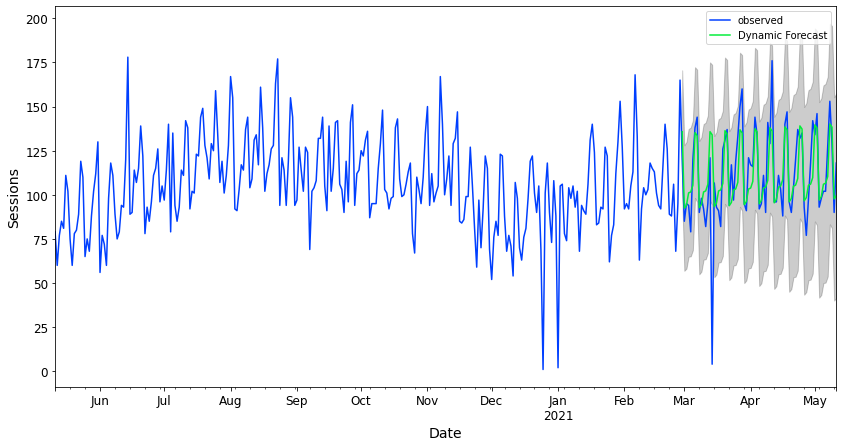

In [36]:
# model = sarima_eva(y,(1, 1, 1),(1, 1, 0, 52),52,'2019-06-02',y_to_val)
split_boundry
model = sarima_eva(y,(1, 1, 1),(1, 1, 1, 7),7,'2021-02-28',y_to_val)

There are a few things to check to help you get the most out of these diagnostic graphs:

1. The top left plot shows the residuals over time. We do not want to see any obvious seasonality here and the messier it is, the better we can say we found the trend and seasonality in our data and removed the noise.

2. In the top-right plot, we want to see that the red KDE line follows closely with the N(0,1) line to indicate that the residuals are normally distributed. This line is the standard notation for a normal distribution with a mean of 0 and a standard deviation of 1.

3. In the bottom left qq-plot, you see the ordered distribution of residuals (blue dots) following the linear trend (red line) of the samples taken from a standard normal distribution with N(0, 1).

4. The autocorrelation visual (called a “correlogram”) on the bottom right shows that the time series residuals have a low correlation with the lagged versions of itself (that is, the majority of dots fall into the blue shaded area).

By validating all the four points above, we can conclude that this model’s residuals are near normally distributed. This indicates we have found a well-fit model suitable for our dataset.

If we were only concerned with achieving the lowest Root Mean Squared Error, we would choose the Simple Exponential Smoothing (SES) model to use since it produced the smallest error. In many business cases where longer-term forecasting with more nuanced visualizations are needed in our overall analysis, the SARIMA model is preferred. 

# Making Predictions
Now that we have a well-fit model, let’s do some forecasting!

To get the forecast for sales in the next year, we enter steps=52. The results produce both a table showing the Predicted_Mean, Lower Bound and Upper Bound, and the prediction graphs.

In [37]:
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

You can see from the visualization that our model clearly captured the seasonality as well as the increasing trend of the sales.

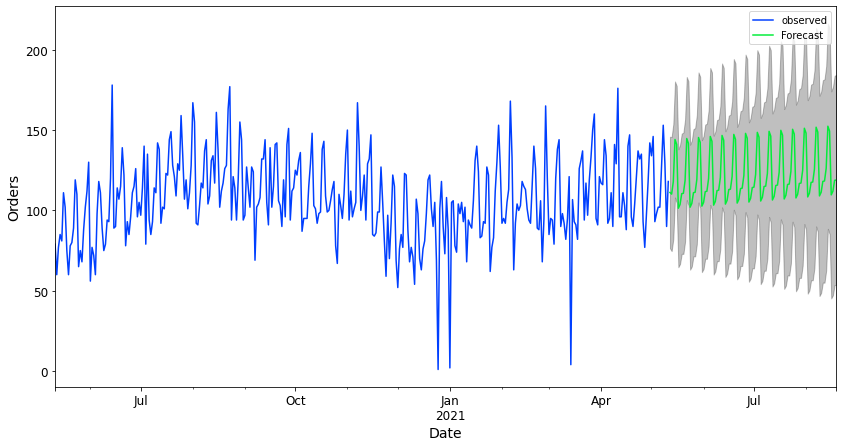

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2021-05-12,111.16057579,76.47233658,145.84881500
1,2021-05-13,110.14687665,74.66227858,145.63147473
2,2021-05-14,117.95879356,82.13905726,153.77852987
3,2021-05-15,144.11026171,107.99091658,180.22960684
4,2021-05-16,141.06708439,104.65356133,177.48060745


In [39]:
final_table = forecast(model,100,y)
final_table.head()

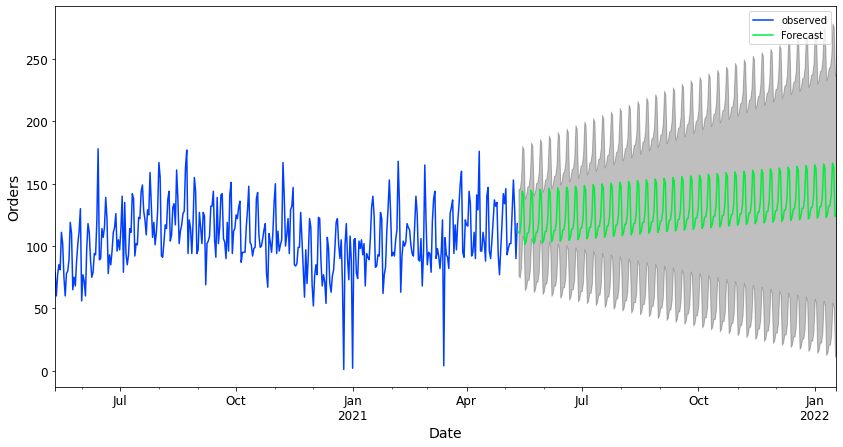

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2021-05-12,111.16057579,76.47233658,145.84881500
1,2021-05-13,110.14687665,74.66227858,145.63147473
2,2021-05-14,117.95879356,82.13905726,153.77852987
3,2021-05-15,144.11026171,107.99091658,180.22960684
4,2021-05-16,141.06708439,104.65356133,177.48060745


In [40]:
final_table = forecast(model,252,y)
final_table.head()

The green line in the graph represents the expected future data based on the forecasting model we built. The green line represents the average forecasted value for each week, and we would not be surprised to see the actual numbers track to this line for the most part. But there is no guarantee of this!

The gray area above and below the green line represents the 95 percent confidence interval and as with virtually all forecasting models, as the predictions go further into the future, the less confidence we have in our values. In this case, we are 95 percent confident that the actual sales will fall inside this range. But, there is a chance the actuals could fall completely outside this range also. The larger the future time period for which we want to predict, the larger this confidence range will be (that is, the less precise our forecast is).

When sharing results with stakeholders, be sure they understand what the confidence interval really means and why it’s important. The results should not be seen as a guaranteed or even expected result, but only as a reference that provides a general picture of the yearly pattern. Lots of uncontrolled factors may heavily influence real-life sales. The sudden onset and huge impacts of COVID-19 present a perfect example of unexpected factors affecting future sales.

# Conclusion
Time series analysis and prediction is a huge and fascinating area with a wide range of complexity and applications. The goal of this blog was to introduce you to the general steps data scientists take to analyze and forecast using time series data. 

I hope this provides you with a solid introduction and guide, and that it answers some of the questions you may have when facing the time series for the first time. I encourage you to continue exploring with time series analyses!

All the code referenced in this post is available here on Github. Please feel free to use it and share your feedback or questions.